<a href="https://colab.research.google.com/github/ndow33/DS-Unit-2-Kaggle-Challenge/blob/master/module4-classification-metrics/LS_DS_224_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [3]:
#make a pipeline
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
#split train into train & val. Make val the same size as test
target = 'status_group'
train, val = train_test_split(train, test_size=len(test),
                              stratify = train[target], random_state=42)

In [0]:
def wrangle(X):
  #makes a copy of the argument that is passed
  X = X.copy()

  #converts date_recorded to datetime
  X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)

  #extract components from date_recorded and drop the original column
  X['year_recorded'] = X['date_recorded'].dt.year
  X['month_recorded'] = X['date_recorded'].dt.month
  X['day_recorded'] = X['date_recorded'].dt.day
  X = X.drop(columns='date_recorded')

  #how many years between construction and current record
  X['years'] = X['year_recorded'] - X['construction_year']

  #Drop recorded_by and id
  unusable_variance = ['recorded_by', 'id']
  X = X.drop(columns= unusable_variance)

  #Drop duplicate columns
  X = X.drop(columns='quantity_group')

  #treat small values of latitude near zero as nan's
  X['latitude'] = X['latitude'].replace(-2e-08, np.nan)

  #columns that have zeros and shouldn't: replace with nan's
  cols_with_zeros = ['construction_year', 'longitude', 'latitude', 'gps_height', 'population']
  for col in cols_with_zeros:
    X[col] = X[col].replace(0, np.nan)

  return X


In [0]:
#wrangle train, validation, and test sets in the same way
train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [0]:
#Arrange data into X features matrix and y target vector

X_train = train.drop(columns = target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test

In [12]:
#Make a pipeline
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

#fit on train, score on val
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)
print('Validation Accuracy: ', accuracy_score(y_val, y_pred))

Validation Accuracy:  0.8140409527789386


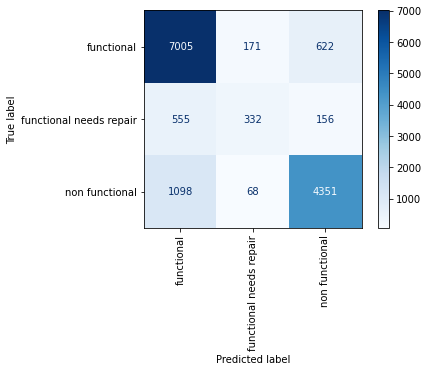

In [13]:
#baseline pipeline with confusion matrix
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(pipeline, X_val, y_val, xticks_rotation = 'vertical',
                      values_format='.0f', cmap='Blues');

In [0]:
import category_encoders as ce
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

target = 'status_group'
features = train.columns.drop([target])
X_train = train[features]
y_train = train[target]

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(random_state=42)
)


In [15]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

param_distributions = {
    'simpleimputer__strategy': ['mean', 'median'],
    'randomforestclassifier__max_depth': [5,10,15,20,None],
    'randomforestclassifier__n_estimators':randint(50,500),
    'randomforestclassifier__max_features': uniform(0,1)
}
    
search = RandomizedSearchCV(
    pipeline,
    param_distributions = param_distributions,
    n_iter=10,
    cv=3,
    scoring='accuracy',
    verbose = 10,
    return_train_score=True,
    n_jobs=-1
)


search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  9.6min
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 15.0min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=None,
                                                             drop_invariant=False,
                                                             handle_missing='value',
                                                             handle_unknown='value',
                                                             mapping=None,
                                                             return_df=True,
                                                             verbose=0)),
                                             ('simpleimputer',
                                              SimpleImputer(add_indicator=False,
                                                            copy=True,
                                                            fill_value=None,


In [0]:
#set the pipeline to the optimal results
pipeline = search.best_estimator_

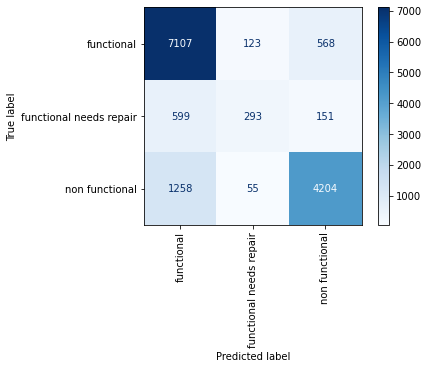

In [17]:
#plot a confusion matrix
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(pipeline, X_val, y_val, xticks_rotation = 'vertical',
                      values_format='.0f', cmap='Blues');